In [90]:
import numpy as np
from numpy import cos, pi
import scipy.io.wavfile as sf
import IPython
import matplotlib.pyplot as plt
from copy import copy

In [91]:
def write_file(data: np.ndarray, file_name: str):
    bits = bytearray()
    for i in range(0, len(data), 8):
        bits.append(int(data[i:i+8], 2))

    with open(file_name, 'bw') as f:
        f.write(bits)

In [92]:
def read_file(file_name: str):
    with open(file_name, 'rb') as f:
        data = f.read()
    return (bin(int.from_bytes(data, byteorder='big')).replace('0b', ''))

In [93]:
def encoder(data: np.ndarray, bits_level: int, max_error):
    data /= max_error
    levels = np.linspace(-1,1,2**bits_level)
    output = "1"
    for sample in data:
        val = np.abs(levels - sample).argmin()
        output += f'0b{val:16b}'[2:].replace(' ', '0')[-bits_level:]
    while len(output) % 16 != 0:
        output += '0'
    return output

In [94]:
def decoder(data: str, bits_level: int, num: int, max_error):
    levels = np.linspace(-1, 1, 2**bits_level)
    zeros = '0' * (bits_level-2)
    result = []
    for i in range(num):
        binary = zeros + data[i*bits_level+1:(i+1)*bits_level+1]
        number = int(binary, 2)
        result.append(levels[number])
    result = np.array(result) * max_error
    return result# 

In [95]:
def levinson(seg: list, samples_ammount: int, ar_rank: int):
    """Levinson-Durbin algorithm

    Args:
        seg (list): Data Segment
        samples_ammount (int): Number of samples in segment
        ar_rank (int): AR rank

    Returns:
        k (list): Reflection coeeficients
    """
    # Calculate autocorrelation coefficients
    p = np.zeros(ar_rank+1)
    for i in range(ar_rank+1):
        for t in range(i, samples_ammount):
            p[i] = p[i] + seg[t] * seg[t-i]
    
    # Solving Yole-Walker equations
    a = np.zeros((ar_rank, ar_rank))
    sigma = np.zeros(11)
    k = np.zeros(10)
    sigma[0] = p[0]
    k[0] = p[1]/p[0]
    a[0,0] = k[0]
    sigma[1] = (1-k[0]**2)*sigma[0]
    for i in range(1, ar_rank):
        x = 0
        for j in range(0, i):
            x = x + a[j,i-1]*p[i-j]
        k[i] = (p[i+1]-x)/sigma[i]
        a[i,i] = k[i]
        for j in range(0, i):
            a[j,i] = a[j, i-1] - k[i]*a[i-j-1, i-1]
        sigma[i+1] = (1-k[i]**2) * sigma[i]
    
    return k

In [96]:
def play_sound(sound, rate=11025):
    return  IPython.display.display(IPython.display.Audio(sound, rate=rate))
# Read wave file
ld_result = sf.read("data/01.wav")
input_arr = np.array(ld_result[1], dtype=float)
input_arr = input_arr / 65536
input_arr = np.concatenate((input_arr, np.zeros(13)))
play_sound(ld_result[1])

/tmp/ipykernel_36563/1367811391.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  ld_result = sf.read("data/01.wav")


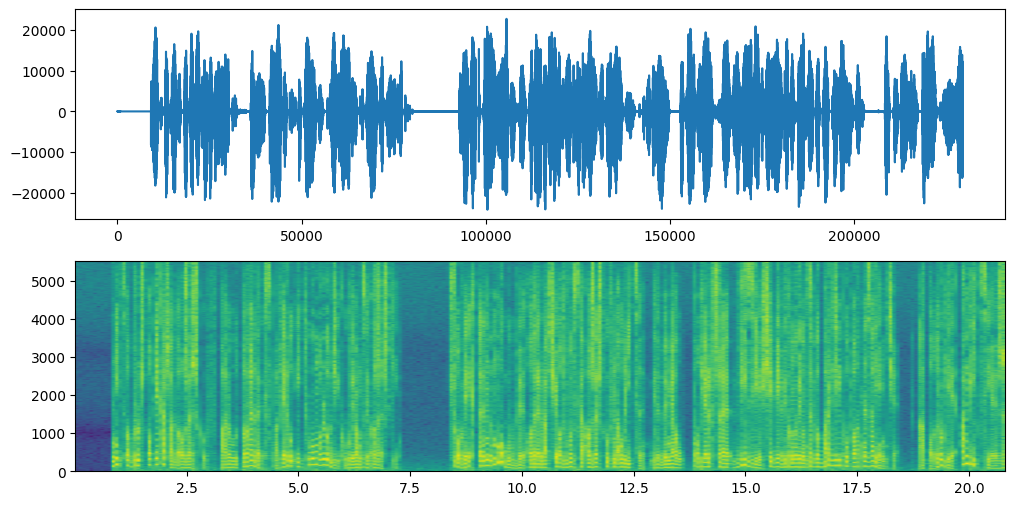

In [97]:
# Ploting track with specgram
plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
plt.plot(ld_result[1])

plt.subplot(2, 1, 2)
plt.specgram(ld_result[1], NFFT=1024, Fs=ld_result[0])

plt.show()

In [98]:
# Weight for flattening edges
def weight(k: np.ndarray):
    weight = 0.5*(1-cos(2*pi*k/(257)))
    weight = np.roll(weight, -1)
    return weight

In [99]:
samples_ammount=256
ar_rank=10

In [100]:
# Transmitter

t = np.arange(samples_ammount)
segment_id = 0

residual_errors = np.zeros((len(input_arr) // samples_ammount) * samples_ammount+1)
max_residual_errors = np.zeros(len(input_arr) // samples_ammount)
ar_coefficients = np.zeros((len(input_arr) // samples_ammount+1) * ar_rank)

while t[-1] < len(input_arr):
        segment_id += 1

        signal = input_arr[t]
        weighted_signal = signal * weight(np.arange(samples_ammount))
        weighted_signal_with_zeros = np.concatenate((np.zeros(ar_rank), weighted_signal, np.zeros(ar_rank)))

        signal_error = np.zeros(samples_ammount)

        ld_result = np.zeros(ar_rank)
        correlation_matrix =  np.correlate(signal, signal, mode='full')
        correlation_matrix = correlation_matrix[0:256]

        ld_result = levinson(weighted_signal_with_zeros, samples_ammount, ar_rank)
        
        if segment_id == 1:
            signal = np.concatenate((np.zeros(ar_rank), signal))
        else:
            signal = np.concatenate((input_arr[t[0]-ar_rank:t[0]], signal))

        for i in range(samples_ammount):
            signal_error[i] = signal[i+ar_rank] + np.sum(signal[i:i+ar_rank][::-1] * ld_result)
        residual_errors[t] = signal_error

        signal_max_error = max(abs(signal_error))
        max_residual_errors[segment_id-1] = signal_max_error
        ar_coefficients[(segment_id-1)*ar_rank:segment_id*ar_rank] = ld_result

        t = t + samples_ammount

In [101]:
# Receiver
def receiver(coefficients, max_errors, errors):
    number_of_segments = len(max_errors)
    reconstructed_signal = np.zeros(ar_rank + number_of_segments*samples_ammount + 1)

    for i in range(number_of_segments):
        sample_index = ar_rank + i * samples_ammount
        segment_signal = np.zeros(samples_ammount)
        new_coefficients = coefficients[i*ar_rank:(i+1)*ar_rank]
        for j in range(samples_ammount):
            next_sample_index = sample_index + j
            segment_signal[j] = -np.sum(reconstructed_signal[next_sample_index-ar_rank:next_sample_index][::-1] * new_coefficients) + errors[i * samples_ammount + j]
        reconstructed_signal[sample_index:sample_index+samples_ammount] = segment_signal

    sf.write('Zrekonstruowane_nagranie.wav', rate=11025, data=reconstructed_signal)
    return reconstructed_signal


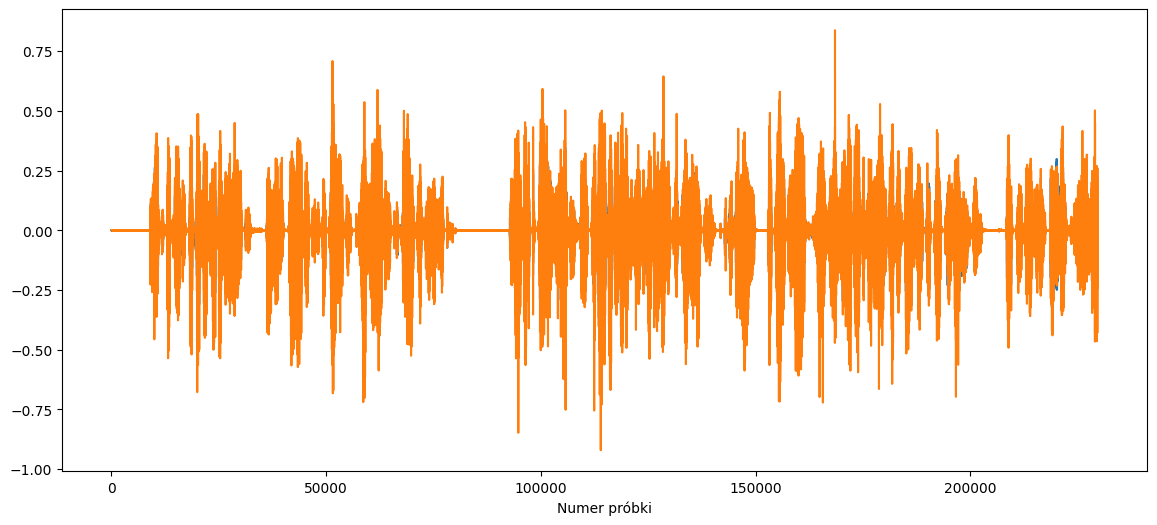

In [102]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(input_arr)
ax.plot(receiver(ar_coefficients, max_residual_errors, residual_errors))
plt.xlabel('Numer próbki')
plt.show()

In [103]:
bits_level = 16

# Save e_max to .bin
binary_max_errors = encoder(max_residual_errors, bits_level, max(abs(max_residual_errors)))
write_file(binary_max_errors, f'e_max_{bits_level}.bin')

# Save coefficients to .bin
binary_ar_coefficients = encoder(ar_coefficients, bits_level, max(abs(ar_coefficients)))
write_file(binary_ar_coefficients, f'coeffs_{bits_level}.bin')

# Save errors to .bin
binary_residual_errors = ""
for i in range(len(max_residual_errors)):
    binary_residual_errors += encoder(residual_errors[i*samples_ammount:(i+1)*samples_ammount], bits_level, max_residual_errors[i])
write_file(binary_residual_errors, f'error_{bits_level}.bin')


In [104]:
# Read e_max from  .bin
bin_read_max_errors = read_file(f'e_max_{bits_level}.bin')
bin_max_errors = decoder(bin_read_max_errors[0:len(max_residual_errors)*bits_level+bits_level], bits_level, len(max_residual_errors), max(abs(max_residual_errors)))

# Read coefficients from .bin
bin_read_coeff = read_file(f'coeffs_{bits_level}.bin')
bin_coefficients = decoder(bin_read_coeff[0:len(ar_coefficients)*bits_level+bits_level], bits_level, len(ar_coefficients), max(abs(ar_coefficients)))

# Read errors from .bin
bin_read_errors = read_file(f'error_{bits_level}.bin')
bin_errors = np.array([])
gap = 0
for i in range(len(bin_max_errors)):
    bin_errors = np.append(bin_errors, decoder(bin_read_errors[i*samples_ammount*bits_level+gap:(i+1)*samples_ammount*bits_level+gap+bits_level], bits_level, samples_ammount, max_residual_errors[i]))
    gap += bits_level

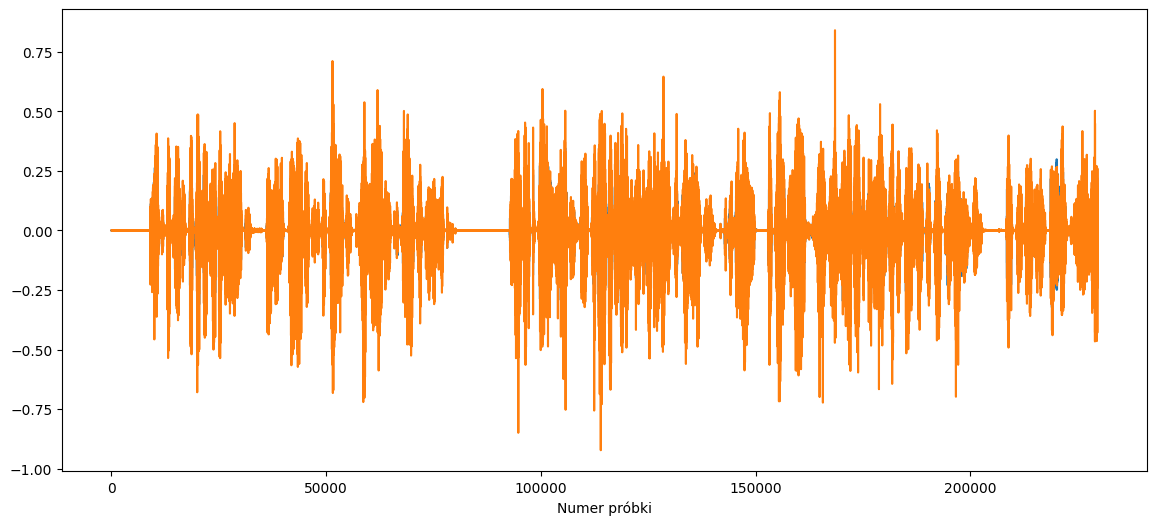

In [105]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(input_arr)
ax.plot(receiver(bin_coefficients, bin_max_errors, bin_errors))
plt.xlabel('Numer próbki')
plt.show()